# Ideal age

The tracer equation for the ideal age is

$$\left(\partial_t + \mathbf{T}\right) \boldsymbol{a} = 1 - \frac{\boldsymbol{a}}{τ} \, (\boldsymbol{z} \le z_0),$$

where the sink term on the right clamps the age to $0$ at the surface (where $\boldsymbol{z} \le z_0$).
The smaller the timescale $\tau$, the quicker $\boldsymbol{a}$ is restored to $0$ at the surface.

AIBECS can interpret tracer equations as long as you arrange them under the generic form:

$$\big(\partial_t + \mathbf{T}(\boldsymbol{p}) \big) \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\mathbf{T}(\boldsymbol{p})$ is the transport, $\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p})$ is the net local sources and sinks, and $\boldsymbol{p}$ is the vector of model parameters.
We will then use the AIBECS to simulate the ideal age by finding the steady-state of the system, i.e., the solution of

$$\partial_t \boldsymbol{x} = \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) - \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x} = 0.$$

In this tutorial, we will simulate the ideal age by
1. defining functions for `T(p)` and `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated ideal age.

We start by telling Julia that we want to use the AIBECS package and the OCIM2 circulation
(the Ocean Circulation Inverse Model, see [1](https://doi.org/10.1029/2018JC014716) for details).

In [1]:
using AIBECS
grd, TOCIM2 = OCIM2.load()

┌ Warning: Over-writing registration of the datadep
│   name = "AIBECS-OCIM2_CTL_He"
└ @ DataDeps ~/.julia/packages/DataDeps/ae6dT/src/registration.jl:15
┌ Info: You are about to use the OCIM2_CTL_He model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., & Holzer, M. (2019). Radiocarbon and helium isotope constraints on deep ocean ventilation and mantle‐³He sources. Journal of Geophysical Research: Oceans, 124, 3036–3057. https://doi.org/10.1029/2018JC014716
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
└ (Look for the "DeVries_Holzer_2019" key.)


(, sparse([1, 2, 10384, 10442, 10443, 20825, 20883, 1, 2, 3  …  200160, 197886, 199766, 199777, 199778, 199779, 199790, 200156, 200159, 200160], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  200159, 200160, 200160, 200160, 200160, 200160, 200160, 200160, 200160, 200160], [0.00019778421518954799, 2.3427916742722093e-9, -1.9599474163829085e-7, -0.00019161212648881556, 4.8096149072091506e-9, -1.830592653460076e-9, 5.007679174162751e-9, -5.025164843241415e-8, 0.00018753126417941492, 4.264266869682882e-8  …  -2.196560075226544e-8, 1.0819937104262028e-10, 6.709812718407374e-9, -1.263521554746615e-9, -3.3927920410468295e-9, 7.593163378667893e-9, -7.410175543096161e-9, -3.441057669604186e-8, -2.0030251520181335e-8, 5.2794476107904204e-8], 200160, 200160))

> **Note**
> If it's your first time, Julia will ask you to download the OCIM2, in which case you should accept (i.e., type `y` and "return").
> Once downloaded, AIBECS will remember where it downloaded the file and it will only load it from your laptop.

`grd` is an `OceanGrid` object containing information about the 3D grid of the OCIM2 circulation and `TOCIM2` is the transport matrix representing advection and diffusion.

The local sources and sinks for the age take the form

In [2]:
function G(x,p)
    @unpack τ, z₀ = p
    return @. 1 - x / τ * (z ≤ z₀)
end

G (generic function with 1 method)

as per the tracer equation.
The `@unpack` line unpacks the parameters `τ` and `z₀`.
The `return` line returns the net sources and sinks.
(The `@.` "macro" tells Julia that the operations apply to every element.)

We can define the vector `z` of depths with `depthvec`.

In [3]:
z = depthvec(grd)

200160-element Vector{Float64}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

Now we must construct a type for `p` the parameters.
This type must contain our parameters `τ` and `z₀`.

In [4]:
struct IdealAgeParameters{U} <: AbstractParameters{U}
    τ::U
    z₀::U
end

The type is now ready for us to generate an instance of the parameter `p`.
Let's use `τ = 1.0` (s) and `z₀` the minimum depth of the model.

In [5]:
p = IdealAgeParameters(1.0, 30.0)

 Row │ Symbol  Value
     │ Symbol  Float64
─────┼─────────────────
   1 │ τ           1.0
   2 │ z₀         30.0

We now use the AIBECS to generate the state function $\boldsymbol{F}$ (and its Jacobian) via

In [6]:
F = AIBECSFunction(TOCIM2, G)

(::SciMLBase.ODEFunction{false, SciMLBase.FullSpecialize, AIBECS.var"#f#58"{Tuple{AIBECS.var"#49#50"{SparseMatrixCSC{Float64, Int64}}}, Vector{Int64}, AIBECS.var"#G#56"{Tuple{typeof(Main.var"##342".G)}, AIBECS.var"#tracers#54"{Int64, Int64}}, AIBECS.var"#tracer#55"{Int64, Int64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, AIBECS.var"#jac#63"{AIBECS.var"#T#60"{Tuple{AIBECS.var"#49#50"{SparseMatrixCSC{Float64, Int64}}}, Int64, Vector{Int64}}, AIBECS.var"#∇ₓG#59"{Tuple{typeof(Main.var"##342".G)}, Int64, Int64}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

Now that `F` and `p` are defined, we are going to solve for the steady-state.
But first, we must create a `SteadyStateProblem` object that contains `F`, `p`, and an initial guess `x_init` for the age.
(`SteadyStateProblem` comes from [SciMLBase](https://github.com/JuliaDiffEq/SciMLBase.jl).)

Let's make a vector of 0's for our initial guess.

In [7]:
nb = sum(iswet(grd))  # number of wet boxes
x_init = zeros(nb)    # Start with age = 0 everywhere

200160-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Now we can create our `SteadyStateProblem` instance

In [8]:
prob = SteadyStateProblem(F, x_init, p)

SteadyStateProblem with uType Vector{Float64}. In-place: false
u0: 200160-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

And finally, we can `solve` this problem, using the AIBECS `CTKAlg()` algorithm,

In [9]:
age = solve(prob, CTKAlg())

u: 200160-element Vector{Float64}:
  804.9793529617992
 2704.2854677669347
  559.462475977662
  277.6810176373405
  571.2245067452855
  406.149152964754
  416.88383377410923
  645.3785433171206
  411.64720879348016
  242.71573068291767
    ⋮
    1.220409865355737e10
    1.1820841832109232e10
    1.3783960333917145e10
    1.3083180539737396e10
    1.1999572353055946e10
    1.1227617212688963e10
    1.340205560821112e10
    1.3322655154055143e10
    1.2121012215573324e10

This should take a few seconds.

To conclude this tutorial, let's have a look at the age using AIBECS' plotting recipes and [Plots.jl](https://github.com/JuliaPlots/Plots.jl).

In [10]:
using Plots

We first convert the age in years
(because the default SI unit we used, i.e., seconds, is a bit small relative to global ocean timescales).

In [11]:
age_in_yrs = age * u"s" .|> u"yr"

200160-element Vector{Quantity{Float64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, nothing}}}:
 2.5508256425133697e-5 yr
  8.569363537680097e-5 yr
 1.7728296067434214e-5 yr
  8.799180471180966e-6 yr
 1.8101012331269976e-5 yr
   1.28700900247406e-5 yr
  1.321025153288302e-5 yr
 2.0450811953923004e-5 yr
 1.3044312900647708e-5 yr
  7.691197387726494e-6 yr
                        ⋮
    386.72454982499835 yr
    374.57987401162416 yr
    436.78734548625823 yr
    414.58097382999324 yr
    380.24350245443077 yr
     355.7817201779908 yr
     424.6855150014931 yr
    422.16946643772474 yr
     384.0916994820051 yr

And we take a horizontal slice at about 2000m.

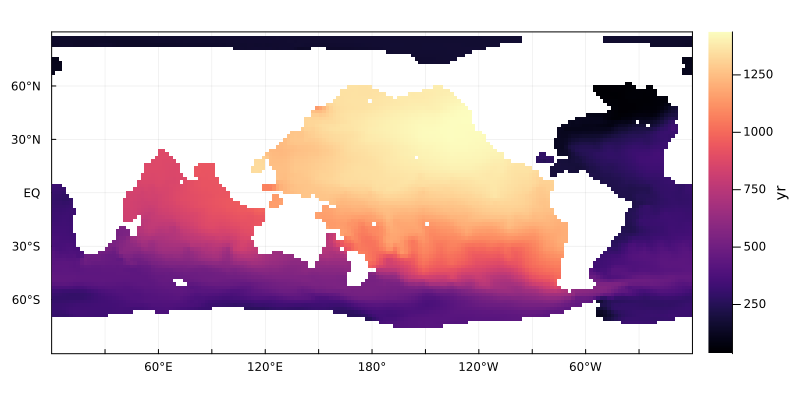

In [12]:
plothorizontalslice(age_in_yrs, grd, depth=2000u"m", color=:magma)

Or look at the horiontal mean

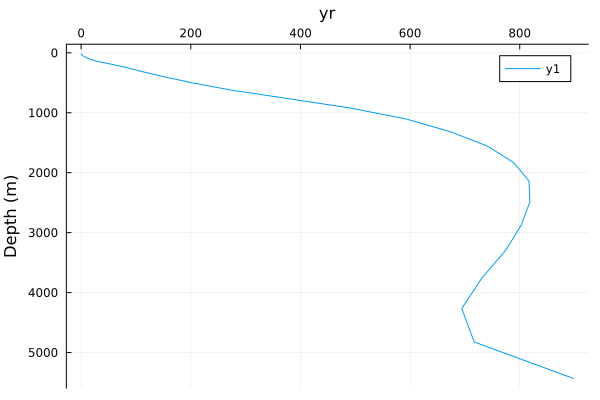

In [13]:
plothorizontalmean(age_in_yrs, grd)

That's it for this tutorial...
Good job!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*